In [45]:
%matplotlib inline
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model
import numpy as np
import pylab as plt
from scipy.sparse import csc_matrix
import matplotlib
from time import process_time
import itertools


def db_rxns(inputs, outputs, EnergyDict, k = 1.):
    dE = sum([EnergyDict[o] for o in outputs])-sum([EnergyDict[i] for i in inputs])
    rxn1 = [inputs, outputs, "massaction", {"k":k*np.exp(-dE/2)}]
    rxn2 = [outputs, inputs, "massaction", {"k":k*np.exp(dE/2)}]
    return [rxn1, rxn2]

def chemostat_db_rxns(inputs, outputs, input_chemostats, output_chemostats, EnergyDict, k = 1):
    dE = sum([EnergyDict[o] for o in outputs])-sum([EnergyDict[i] for i in inputs])
    
    kf = ""
    for i in input_chemostats+inputs:
        kf += i+"*"
    kf += str(np.exp(-dE/2)*k)
    
    kr = ""
    for o in output_chemostats+outputs:
        kr += o + "*"
    kr += str(np.exp(dE/2)*k)
    
    rxn1 = [inputs, outputs, "general", {"rate":kf}]
    rxn2 = [outputs, inputs, "general", {"rate":kr}]
    #print(inputs, "-->", outputs, "@", kf)
    #print(outputs, "-->", inputs, "@", kr)
    return [rxn1, rxn2]

def add_learning_rule(M, P, Q, X, k, dt):
    if isinstance(k, tuple):
        k1 = k[0]
        k2 = k[1]
    else:
        k1 = k
        k2 = k
    M.create_rule("assignment", {"equation":f"{P} = {P}+{P}*({k1}*{X}-{k2}*{Q})*{dt}"})

Text(0, 0.5, 'Concentration')

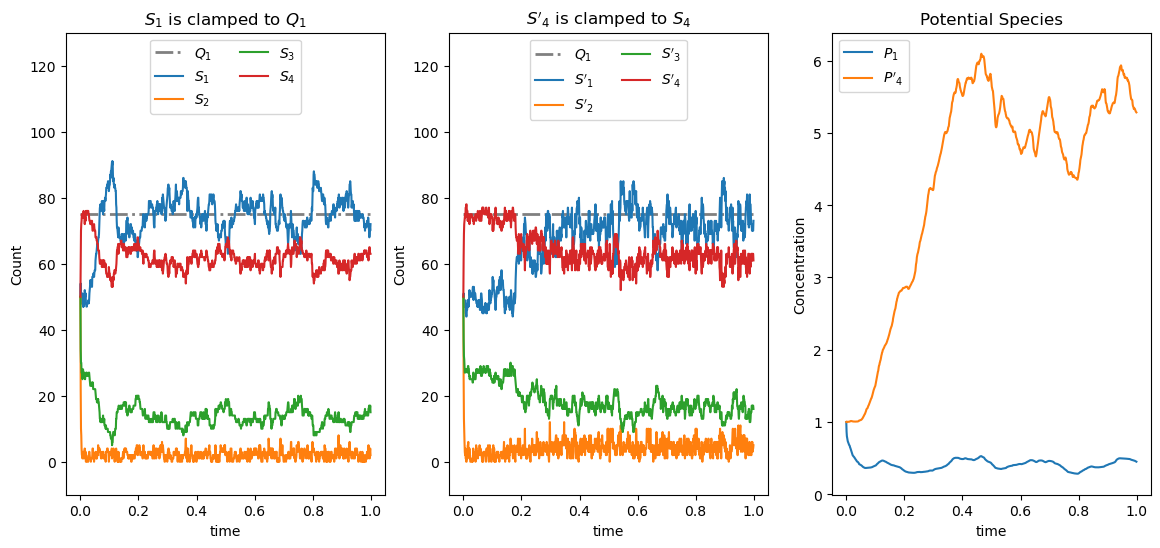

In [44]:
species_Q = ["Q1"]
species_Sc = ["Sc1", "Sc2", "Sc3", "Sc4"]
species_Pc = ["Pc1"]
species_Sf = ["Sf1", "Sf2", "Sf3", "Sf4"]
species_Pf = ["Pf2", "Pf3", "Pf4"]
k_db = 10.0
k_clamp = 0.1
k_learn = 0.1
dt = 0.001

species = species_Q+species_Sc+species_Pc+species_Sf+species_Pf
E = {s:0 for s in species}
reactions = []

def learning_reactions(S, Q, P, k):
    rxns = []
    rxns.append(([Q, P], [Q], "massaction", {"k":k}))
    rxns.append(([S, P], [S, P, P], "massaction", {"k":k}))
    return rxns

reactions += chemostat_db_rxns(["Sc1"], ["Sc2", "Sc3"], ["Pc1"], [], E, k = k_db)
reactions += chemostat_db_rxns(["Sc1", "Sc2"], ["Sc4"], ["Pc1"], [], E, k = k_db)

reactions += chemostat_db_rxns(["Sf1"], ["Sf2", "Sf3"], [],[], E, k = k_db)
reactions += chemostat_db_rxns(["Sf1", "Sf2"], ["Sf4"], [], ["Pf4"], E, k = k_db)

x0 = {
    s : 50 for s in species_Sc+species_Sf
}
x0.update({s : 1.0 for s in species_Pc + species_Pf})

x0["Q1"] = 75

Mf = Model(species = species, reactions = reactions, initial_condition_dict = x0)
M = Model(species = species, reactions = reactions, initial_condition_dict = x0)

add_learning_rule(M, "Pc1", "Q1", "Sc1", k_clamp, dt)
#add_learning_rule(M, "Pf2", "Sc2", "Sf2", k_learn, dt)
#add_learning_rule(M, "Pf3", "Sc3", "Sf3", k_learn, dt)
add_learning_rule(M, "Pf4", "Sc4", "Sf4", k_learn, dt)




timepoints = np.arange(0, 1.0, dt)
R = py_simulate_model(timepoints, M, stochastic = True, return_dataframe = True)


plt.figure(figsize = (14, 6))

plt.subplot(131)
plt.title("$S_1$ is clamped to $Q_1$")
plt.plot(timepoints, R["Q1"], "-.", label = "$Q_1$", lw = 2, color = 'gray')
plt.plot(timepoints, R["Sc1"], label = "$S_1$")
plt.plot(timepoints, R["Sc2"], label = "$S_2$")
plt.plot(timepoints, R["Sc3"], label = "$S_3$")
plt.plot(timepoints, R["Sc4"], label = "$S_4$")
plt.legend(ncol = 2, loc = "upper center")
plt.ylim(-10, 130)
plt.ylabel("Count")
plt.xlabel("time")

plt.subplot(132)
plt.title("$S'_4$ is clamped to $S_4$")
plt.plot(timepoints, R["Q1"], "-.", label = "$Q_1$", lw = 2, color = 'gray')
plt.plot(timepoints, R["Sf1"], label = "$S'_1$")
plt.plot(timepoints, R["Sf2"], label = "$S'_2$")
plt.plot(timepoints, R["Sf3"], label = "$S'_3$")
plt.plot(timepoints, R["Sf4"], label = "$S'_4$")
plt.legend(ncol = 2, loc = "upper center")
plt.ylim(-10, 130)
plt.ylabel("Count")
plt.xlabel("time")

plt.subplot(133)
plt.title("Potential Species")
plt.plot(timepoints, R["Pc1"], label = "$P_1$")
plt.plot(timepoints, R["Pf4"], label = "$P'_4$")
plt.legend()
plt.xlabel("time")
plt.ylabel("Concentration")




